We try to use FlagRep to represent pieces of the indian pines dataset as flags. Then, we use chordal distance between flags to build a distance matrix. Finally, we use MDS and tSNE to visualize the data distribution in 2 dimensions.

Some details:
- A patch of data is a set of pixels, all of the same class, stacked into the data matrix that is (n-pixels) x (n_bands)
- Collecting patches of the data is either done by neighboring pixels or randomly. Using neighboring pixels results in a non-seniscal MDS visualization. So we prefer random selection.
- We also try collecting all the data from one class into one data matrix. Then visualizing the differences between classes. This is again, not that informative. 


In [3]:
import numpy as np
import scipy

from FlagRep import FlagRep, chordal_distance

from matplotlib import pyplot as plt

from sklearn.manifold import MDS
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA



import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split



In [4]:
def make_Bs(fl_type):
    Bs = [np.arange(fl_type[0])]
    for i in range(1,len(fl_type)):
        Bs.append(np.arange(fl_type[i-1],fl_type[i]))
    return Bs

In [5]:
def extract_patches_of_class(data, labels, patch_size, target_class):
    """
    Extract patches where all pixels in the patch are of the target class.

    :param data: The hyperspectral image data.
    :param labels: The ground truth labels.
    :param patch_size: Size of the patch (e.g., 7 for 7x7 patches).
    :param target_class: The class for which patches should be extracted.
    :return: A list of patches (each patch is of size patch_size x patch_size x num_bands).
    """
    half_patch = patch_size // 2
    patches = []
    patch_labels = []

    # Iterate through the image, avoiding border pixels (due to patch size)
    for i in range(half_patch, data.shape[0] - half_patch):
        for j in range(half_patch, data.shape[1] - half_patch):
            if labels[i, j] == target_class:
                # Extract the patch from both the data and the labels
                label_patch = labels[i - half_patch:i + half_patch + 1, j - half_patch:j + half_patch + 1]
                
                # Check if all pixels in the label patch are of the target class
                if np.all(label_patch == target_class):
                    # Extract the corresponding data patch
                    patch = data[i - half_patch:i + half_patch + 1, j - half_patch:j + half_patch + 1, :]
                    patches.append(patch)
                    patch_labels.append(target_class)

    return np.array(patches), np.array(patch_labels)

#Train and evaluate kNN classifier with precomputed distances
def evaluate_knn_with_distances(distance_matrix_train, distance_matrix_test, y_train, y_test, k_values):
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k, metric='precomputed')
        
        # Fit the model using the training distance matrix and labels
        knn.fit(distance_matrix_train, y_train)
        
        # Predict using the test distance matrix
        y_pred = knn.predict(distance_matrix_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"k={k}, Accuracy: {accuracy:.4f}")

#Train and evaluate kNN classifier with precomputed distances
def evaluate_knn(data_train, data_test, y_train, y_test, k_values):
    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        
        # Fit the model using the training distance matrix and labels
        knn.fit(data_train, y_train)
        
        # Predict using the test distance matrix
        y_pred = knn.predict(data_test)
        
        # Calculate accuracy
        accuracy = accuracy_score(y_test, y_pred)
        print(f"k={k}, Accuracy: {accuracy:.4f}")

In [6]:
class_names = {1: 'Scrub',
               2: 'Willow swamp',
               3: 'Cabbage palm hammock',
               4: 'Cabbage palm/oak hammock',
               5: 'Slash pine',
               6: 'Oak/broad leaf hammock',
               7: 'Hardwood swamp',
               8: 'Graminoid marsh',
               9: 'Spartina marsh',
               10: 'Cattail marsh',
               11: 'Salt marsh',
               12: 'Mudflats',
               13: 'Water'}

In [7]:


# Load the hyperspectral image and ground truth
data = scipy.io.loadmat('../data/KSC/KSC.mat')['KSC']
labels = scipy.io.loadmat('../data/KSC/KSC_gt.mat')['KSC_gt']



In [8]:
data.shape

(512, 614, 176)

In [9]:
patch_size = 7

In [10]:
mod_data = []
mod_labels = []
for target_class in np.unique(labels)[1:-1]:
    patches, patch_labels = extract_patches_of_class(data, labels, patch_size, target_class)
    if len(patches) > 0:
        flat_patches = [patch.reshape(patch_size**2,176) for patch in patches]
        mod_labels +=[target_class]*len(patches)
        mod_data += flat_patches

    print(f"Extracted {len(patches)} patches where all pixels are of class {class_names[target_class]}. Each patch has shape {patch_size}.")

Extracted 78 patches where all pixels are of class Scrub. Each patch has shape 7.
Extracted 0 patches where all pixels are of class Willow swamp. Each patch has shape 7.
Extracted 0 patches where all pixels are of class Cabbage palm hammock. Each patch has shape 7.
Extracted 0 patches where all pixels are of class Cabbage palm/oak hammock. Each patch has shape 7.
Extracted 12 patches where all pixels are of class Slash pine. Each patch has shape 7.
Extracted 4 patches where all pixels are of class Oak/broad leaf hammock. Each patch has shape 7.
Extracted 7 patches where all pixels are of class Hardwood swamp. Each patch has shape 7.
Extracted 25 patches where all pixels are of class Graminoid marsh. Each patch has shape 7.
Extracted 84 patches where all pixels are of class Spartina marsh. Each patch has shape 7.
Extracted 15 patches where all pixels are of class Cattail marsh. Each patch has shape 7.
Extracted 77 patches where all pixels are of class Salt marsh. Each patch has shape 7.

Text(0, 0.5, 'PC2')

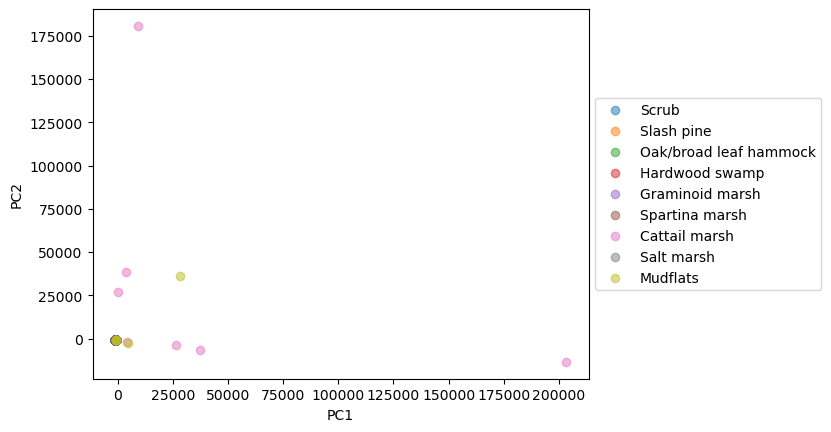

In [11]:
pca = PCA(n_components = 2)
vis_data = pca.fit_transform(np.vstack([m.flatten() for m in mod_data]))

unique_labels = np.unique(mod_labels)
for l in unique_labels:
    idx = np.where(mod_labels == l)
    plt.scatter(vis_data[idx,0], vis_data[idx,1], alpha=.5, label = class_names[l])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('PC1')
plt.ylabel('PC2')

[array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 3

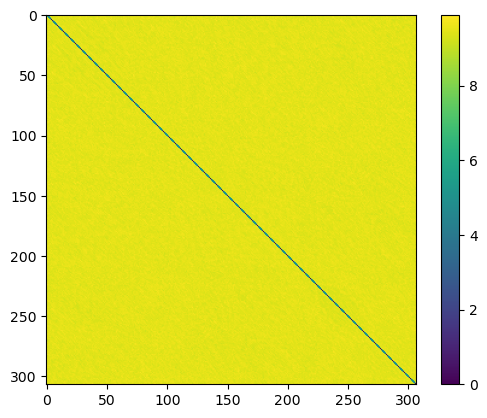

In [12]:
Aset = [np.arange(10),np.arange(30),np.arange(100)]
mod_flags = []
mod_f_types = []
for pt in mod_data:
    flag_pt, f_type = FlagRep(pt, Aset)
    mod_flags.append(flag_pt)
    mod_f_types.append(f_type)

p = len(mod_f_types)
dist_mat = np.zeros((p,p))
for i in range(p):
    for j in range(i+1,p):
        x = mod_flags[i]
        y = mod_flags[j]
        fl_type_x = mod_f_types[i]
        fl_type_y = mod_f_types[j]
        Bs_x = make_Bs(fl_type_x)
        Bs_y = make_Bs(fl_type_y)
        dist = chordal_distance(x, y, Bs_x, Bs_y)
        dist_mat[i,j] = dist
        dist_mat[j,i] = dist

print(mod_f_types)

plt.imshow(dist_mat)
plt.colorbar()
        

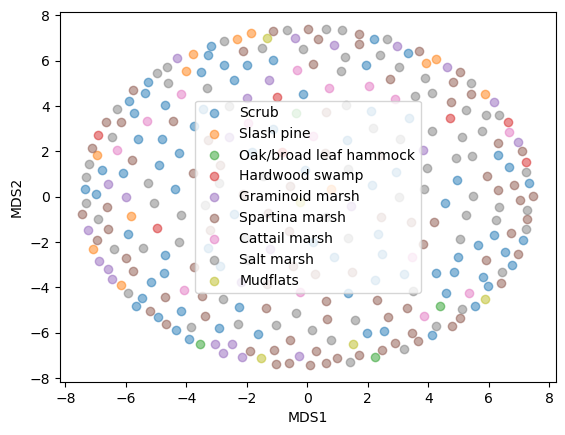

In [13]:
classes = np.unique(labels)

mds = MDS(n_components=2,dissimilarity='precomputed')
vis_data = mds.fit_transform(dist_mat)

unique_labels = np.unique(mod_labels)
for l in unique_labels:
    idx = np.where(mod_labels == l)
    plt.scatter(vis_data[idx,0], vis_data[idx,1], alpha=.5, label = class_names[l])
plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.legend()

Text(0, 0.5, 't-SNE2')

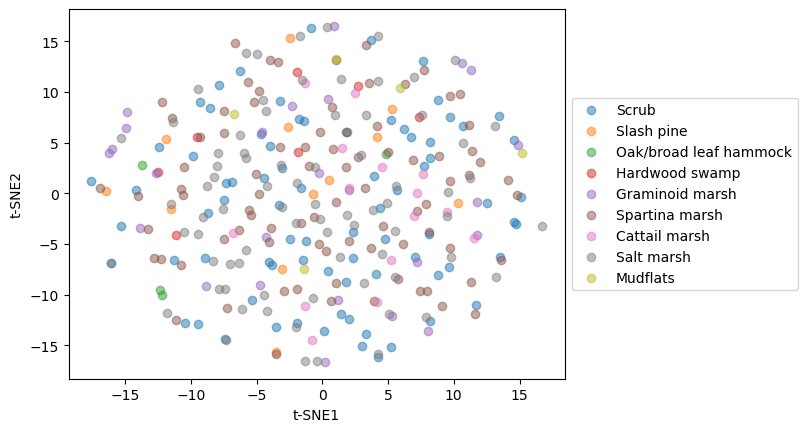

In [14]:

tsne = TSNE(n_components=2,metric='precomputed', init = "random", random_state = 10)
vis_data = tsne.fit_transform(dist_mat)

unique_labels = np.unique(mod_labels)
for l in unique_labels:
    idx = np.where(mod_labels == l)
    plt.scatter(vis_data[idx,0], vis_data[idx,1], alpha=.5, label = class_names[l])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

In [15]:



# Step 1: Create an array of indices corresponding to the data
indices = np.arange(len(mod_labels))
mod_labels = np.array(mod_labels)

# Step 2: Perform train-test split based on labels using the indices
train_indices, test_indices, _, _ = train_test_split(indices, mod_labels, test_size=0.3, stratify=mod_labels, random_state=42)

# Step 3: Use these indices to retrieve the corresponding data and labels
# (This step assumes `data` is an array of the same length as `labels`)

distance_matrix_train = dist_mat[train_indices,:][:,train_indices]
distance_matrix_test = dist_mat[test_indices,:][:,train_indices]
y_train = mod_labels[train_indices]
y_test = mod_labels[test_indices]

# Step 5: Test for different values of k (number of neighbors)
k_values = [1, 3, 5, 7]
evaluate_knn_with_distances(distance_matrix_train, distance_matrix_test, y_train, y_test, k_values)


k=1, Accuracy: 0.2688
k=3, Accuracy: 0.2581
k=5, Accuracy: 0.3011
k=7, Accuracy: 0.2581


[array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 30, 49]), array([10, 3

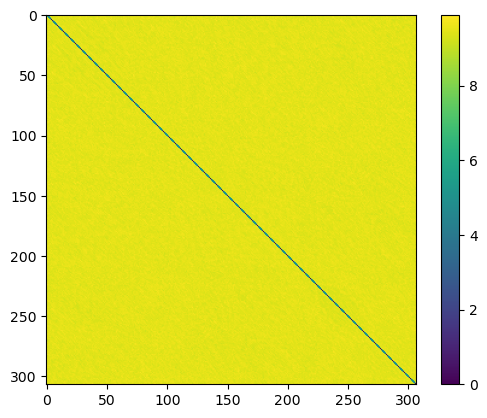

In [18]:


n_sing_vals = np.max(np.vstack(mod_f_types))

mod_svds = []
svd_f_types = []
for x in mod_data:
    U,_,_ = np.linalg.svd(x)
    mod_svds.append(U[:,:n_sing_vals])
    svd_f_types.append(list(np.arange(1,n_sing_vals+1)))

p = len(mod_f_types)
dist_mat = np.zeros((p,p))
for i in range(p):
    for j in range(i+1,p):
        x = mod_flags[i]
        y = mod_flags[j]
        fl_type_x = mod_f_types[i]
        fl_type_y = mod_f_types[j]
        Bs_x = make_Bs(fl_type_x)
        Bs_y = make_Bs(fl_type_y)
        dist = chordal_distance(x, y, Bs_x, Bs_y)
        dist_mat[i,j] = dist
        dist_mat[j,i] = dist

print(mod_f_types)

plt.imshow(dist_mat)
plt.colorbar()

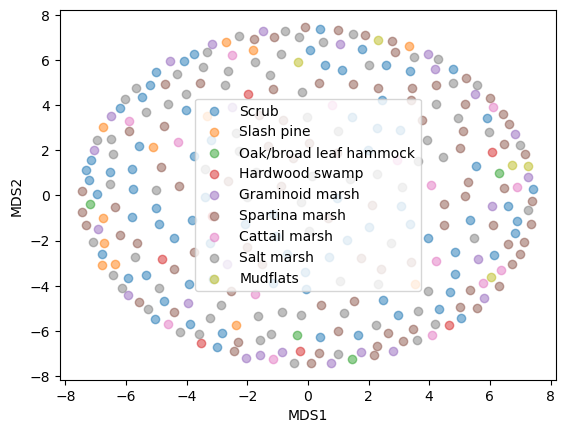

In [19]:
classes = np.unique(labels)

mds = MDS(n_components=2,dissimilarity='precomputed')
vis_data = mds.fit_transform(dist_mat)

unique_labels = np.unique(mod_labels)
for l in unique_labels:
    idx = np.where(mod_labels == l)
    plt.scatter(vis_data[idx,0], vis_data[idx,1], alpha=.5, label = class_names[l])
plt.xlabel('MDS1')
plt.ylabel('MDS2')
plt.legend()

In [ ]:

tsne = TSNE(n_components=2,metric='precomputed', init = "random", random_state = 10)
vis_data = tsne.fit_transform(dist_mat)

unique_labels = np.unique(mod_labels)
for l in unique_labels:
    idx = np.where(mod_labels == l)
    plt.scatter(vis_data[idx,0], vis_data[idx,1], alpha=.5, label = class_names[l])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')

In [ ]:



# Step 1: Create an array of indices corresponding to the data
indices = np.arange(len(mod_labels))
mod_labels = np.array(mod_labels)

# Step 2: Perform train-test split based on labels using the indices
train_indices, test_indices, _, _ = train_test_split(indices, mod_labels, test_size=0.3, stratify=mod_labels, random_state=42)

# Step 3: Use these indices to retrieve the corresponding data and labels
# (This step assumes `data` is an array of the same length as `labels`)

distance_matrix_train = dist_mat[train_indices,:][:,train_indices]
distance_matrix_test = dist_mat[test_indices,:][:,train_indices]
y_train = mod_labels[train_indices]
y_test = mod_labels[test_indices]

# Step 5: Test for different values of k (number of neighbors)
k_values = [1, 3, 5, 7]
evaluate_knn_with_distances(distance_matrix_train, distance_matrix_test, y_train, y_test, k_values)
